In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from nipy.modalities.fmri.hemodynamic_models import spm_hrf
import numpy as np
import pandas as pd
import nibabel as nib
import os
from src.nibetaseries.interfaces.nistats import BetaSeries
import nipype.pipeline.engine as pe
from nipype.interfaces import utility as niu

In [2]:
data_out = './data/simulation_data/'
os.makedirs(data_out, exist_ok=True)
events_file = os.path.join(data_out, 'sub-test01_task-whodis_events.tsv')
bold_file = os.path.join(data_out, 'sub-test01_task-whodis_bold.nii.gz')
brainmask_file = os.path.join(data_out, 'sub-test01_task-whodis_bold_brainmask.nii.gz')
confounds_file = os.path.join(data_out, 'sub-test01_task-whodis_bold_confounds.tsv')

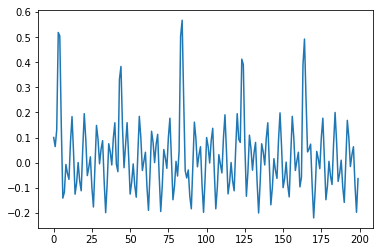

In [25]:
tr = 2 # repetition time 2 seconds
tp = 200 # time_points
ix = np.arange(tp)

task_onsets = np.zeros(tp) # create voxel timeseries
task_onsets[0::40] = 1 # add activations at every 40 time points

# create voxel timeseries

# signal
signal = np.convolve(task_onsets, spm_hrf(tr, oversampling=1, time_length=32))[0:len(task_onsets)]

# csf
csf = np.cos(2*np.pi*ix*(50/tp)) * 0.1

# white matter
wm = np.sin(2*np.pi*ix*(22/tp)) * 0.1

# voxel time series (signal and noise)
voxel_ts = signal + csf + wm

img_data = np.array([[[voxel_ts, voxel_ts]]]) # a 4d matrix with 2 identical timeseries
img = nib.Nifti1Image(img_data, np.eye(4)) # make a nifti image
img.to_filename(bold_file) # save the nifti image
plt.plot(voxel_ts)

# save the confounds 
confounds_df = pd.DataFrame({'WhiteMatter': wm, 'CSF': csf})
confounds_df.to_csv(confounds_file, index=False, sep='\t')

# make the brainmask
bm_data = np.array([[[1, 1]]], dtype=np.int16)
bm_img = nib.Nifti1Image(bm_data, np.eye(4)) # make a nifti image
bm_img.to_filename(brainmask_file) # save the nifti image

# make bold metadata
bold_metadata = {'RepetitionTime': tr}

In [28]:
# create event tsv
onsets = np.multiply(np.where(task_onsets == 1), tr).reshape(5)
durations = [1] * onsets.size
trial_types = ['testCond'] * onsets.size

events_df = pd.DataFrame.from_dict({'onset': onsets, 'duration': durations, 'trial_type': trial_types})
# reorder columns
events_df = events_df[['onset', 'duration', 'trial_type']]
# save the events_df to file
events_df.to_csv(events_file, index=False, sep='\t')
events_df

,onset,duration,trial_type
0,0,1,testCond
1,80,1,testCond
2,160,1,testCond
3,240,1,testCond
4,320,1,testCond


In [29]:
betaseries = BetaSeries(bold_file=bold_file,
                      bold_metadata=bold_metadata,
                      confounds_file=confounds_file,
                      events_file=events_file,
                      hrf_model='spm + derivative + dispersion',
                      low_pass=None,
                      mask_file=brainmask_file,
                      selected_confounds = ['WhiteMatter', 'CSF'],
                      smoothing_kernel=0.0)

res = betaseries.run()

     WhiteMatter           CSF
0       0.000000  1.000000e-01
1       0.063742  6.123234e-18
2       0.098229 -1.000000e-01
3       0.087631 -1.836970e-17
4       0.036812  1.000000e-01
5      -0.030902  3.061617e-17
6      -0.084433 -1.000000e-01
7      -0.099211 -4.286264e-17
8      -0.068455  1.000000e-01
9      -0.006279  5.510911e-17
10      0.058779 -1.000000e-01
11      0.096858 -2.449913e-16
12      0.090483  1.000000e-01
13      0.042578 -9.803364e-17
14     -0.024869 -1.000000e-01
15     -0.080902 -2.694842e-16
16     -0.099803  1.000000e-01
17     -0.072897 -7.354071e-17
18     -0.012533 -1.000000e-01
19      0.053583 -2.939771e-16
20      0.095106  1.000000e-01
21      0.092978 -4.904777e-17
22      0.048175 -1.000000e-01
23     -0.018738 -3.184701e-16
24     -0.077051  1.000000e-01
25     -0.100000 -2.455483e-17
26     -0.077051 -1.000000e-01
27     -0.018738 -3.429630e-16
28      0.048175  1.000000e-01
29      0.092978 -6.189806e-20
..           ...           ...
170    -

Computing run 1 out of 1 runs (go take a coffee, a big one)
/home/james/.conda/envs/nibetaseries/lib/python3.6/site-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Converting to None (no smoothing option)
  .format(fwhm))
/home/james/.conda/envs/nibetaseries/lib/python3.6/site-packages/nistats/first_level_model.py:465: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  labels, results = mem_glm(Y, design.as_matrix(),

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)
/home/james/.conda/envs/nibetaseries/lib/python3.6/site-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Converting to None (no smoothing option)
  .format(fwhm))

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)
/home/james/.conda/envs/nibetaseries/lib/python3.6/site

In [30]:
output = res.outputs.beta_maps

In [31]:
beta_map = nib.load(output)
beta_map.get_data()

array([[[[194.04354221, 193.74790288, 194.69345833, 194.88330127,
          195.59639601],
         [194.04354221, 193.74790288, 194.69345833, 194.88330127,
          195.59639601]]]])

     WhiteMatter           CSF
0       0.000000  1.000000e-01
1       0.063742  6.123234e-18
2       0.098229 -1.000000e-01
3       0.087631 -1.836970e-17
4       0.036812  1.000000e-01
5      -0.030902  3.061617e-17
6      -0.084433 -1.000000e-01
7      -0.099211 -4.286264e-17
8      -0.068455  1.000000e-01
9      -0.006279  5.510911e-17
10      0.058779 -1.000000e-01
11      0.096858 -2.449913e-16
12      0.090483  1.000000e-01
13      0.042578 -9.803364e-17
14     -0.024869 -1.000000e-01
15     -0.080902 -2.694842e-16
16     -0.099803  1.000000e-01
17     -0.072897 -7.354071e-17
18     -0.012533 -1.000000e-01
19      0.053583 -2.939771e-16
20      0.095106  1.000000e-01
21      0.092978 -4.904777e-17
22      0.048175 -1.000000e-01
23     -0.018738 -3.184701e-16
24     -0.077051  1.000000e-01
25     -0.100000 -2.455483e-17
26     -0.077051 -1.000000e-01
27     -0.018738 -3.429630e-16
28      0.048175  1.000000e-01
29      0.092978 -6.189806e-20
..           ...           ...
170    -

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds



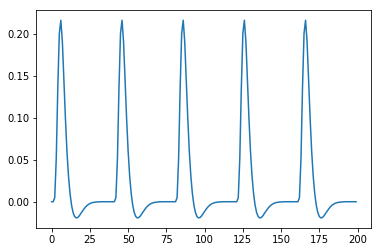

In [8]:
# no noise
voxel_ts_noiseless = signal

img_data = np.array([[[voxel_ts_noiseless, voxel_ts_noiseless]]]) # a 4d matrix with 2 identical timeseries
img = nib.Nifti1Image(img_data, np.eye(4)) # make a nifti image
img.to_filename(bold_file) # save the nifti image
plt.plot(voxel_ts_noiseless)
betaseriesns = BetaSeries(bold_file=bold_file,
                      bold_metadata=bold_metadata,
                      confounds_file=confounds_file,
                      events_file=events_file,
                      hrf_model='spm + derivatives',
                      low_pass=None,
                      mask_file=brainmask_file,
                      selected_confounds=[],
                      smoothing_kernel=0.0)

resns = betaseries.run()

In [32]:
outputns = resns.outputs.beta_maps
beta_mapns = nib.load(outputns)
beta_mapns.get_data()

array([[[[194.04354221, 193.74790288, 194.69345833, 194.88330127,
          195.59639601],
         [194.04354221, 193.74790288, 194.69345833, 194.88330127,
          195.59639601]]]])

In [26]:
design_matrix = resns.outputs.design_matrices[0]
design_matrix['voxel'] = voxel_ts
design_matrix['signal'] = signal

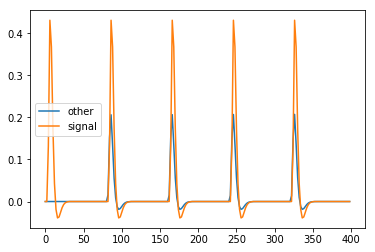

In [27]:
design_matrix[['other', 'signal']].plot()

In [12]:
import statsmodels.formula.api as smf

In [13]:
all_columns = "+".join([x for x in design_matrix.columns.values if x != "voxel"])
model = smf.ols('voxel ~ ' + all_columns, data=design_matrix)
res = model.fit()

In [14]:
res.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  voxel   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.489e+31
Date:                Thu, 11 Oct 2018   Prob (F-statistic):               0.00
Time:                        14:05:18   Log-Likelihood:                 7131.5
No. Observations:                 200   AIC:                        -1.424e+04
Df Residuals:                     187   BIC:                        -1.419e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3.469e-18   3.22e-18     -1.077      0.283   -9.83e-18    2.89e-18
other                1.388e-16   1.47e-16      0.947      0.345    -1.5e-16    4.28e-16
other_derivative    -1.665e-16   4.73e-16     -0.352      0.725    -1.1e-15    7.66e-16
testCond            -8.743e-16   3.02e-16     -2.890      0.004   -1.47e-15   -2.78e-16
testCond_derivative -7.772e-16   8.67e-16     -0.897      0.371   -2.49e-15    9.33e-16
WhiteMatter             1.0000   8.31e-17    1.2e+16      0.000       1.000       1.000
CSF                     1.0000   8.47e-17   1.18e+16      0.000       1.000       1.000
drift_1             -4.198e-16   8.35e-17     -5.027      0.000   -5.85e-16   -2.55e-16
drift_2             -9.021e-17   8.35e-17     -1.081      0.281   -2.55e-16    7.45e-17
drift_3             -4.961e-16   8.35e-17     -5.938      0.000   -6.61e-16   -3.31e-16
drift_4             -1.509e-16   8.35e-17     -1.808      0.072   -3.16e-16    1.37e-17
drift_5             -4.354e-16   8.37e-17     -5.204      0.000      -6e-16    -2.7e-16
constant            -2.255e-17   3.22e-18     -7.000      0.000   -2.89e-17   -1.62e-17
signal                  1.0000   1.08e-16   9.27e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                        9.887   Durbin-Watson:                   0.369
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.336
Skew:                           0.456   Prob(JB):                      0.00570
Kurtosis:                       3.638   Cond. No.                     2.83e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  5e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [15]:
design_matrix

,other,other_derivative,testCond,testCond_derivative,WhiteMatter,CSF,drift_1,drift_2,drift_3,drift_4,drift_5,constant,voxel,signal
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e-01,0.099997,0.099988,0.099972,0.099951,0.099923,1.0,0.100000,0.000000e+00
2.0,0.000000,0.000000,0.016804,0.033978,0.063742,6.123234e-18,0.099972,0.099889,0.099750,0.099556,0.099307,1.0,0.063742,3.492027e-10
4.0,0.000000,0.000000,0.153943,0.069218,0.098229,-1.000000e-01,0.099923,0.099692,0.099307,0.098769,0.098079,1.0,0.003097,4.867918e-03
6.0,0.000000,0.000000,0.205951,-0.016064,0.087631,-1.836970e-17,0.099849,0.099396,0.098643,0.097592,0.096246,1.0,0.139039,5.140867e-02
8.0,0.000000,0.000000,0.132636,-0.045664,0.036812,1.000000e-01,0.099750,0.099002,0.097760,0.096029,0.093819,1.0,0.272339,1.355263e-01
10.0,0.000000,0.000000,0.054278,-0.031780,-0.030902,3.061617e-17,0.099627,0.098511,0.096660,0.094088,0.090814,1.0,0.169915,2.008167e-01
12.0,0.000000,0.000000,0.008462,-0.016022,-0.084433,-1.000000e-01,0.099479,0.097922,0.095345,0.091775,0.087250,1.0,0.032134,2.165669e-01
14.0,0.000000,0.000000,-0.012572,-0.006213,-0.099211,-4.286264e-17,0.099307,0.097237,0.093819,0.089101,0.083147,1.0,0.091535,1.907469e-01
16.0,0.000000,0.000000,-0.018690,-0.000503,-0.068455,1.000000e-01,0.099110,0.096456,0.092085,0.086074,0.078532,1.0,0.177143,1.455974e-01
18.0,0.000000,0.000000,-0.016655,0.002193,-0.006279,5.510911e-17,0.098889,0.095579,0.090146,0.082708,0.073432,1.0,0.092800,9.907920e-02
